In [347]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from scipy.io.arff import loadarff 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_iris, load_wine
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import StratifiedKFold, HalvingGridSearchCV, KFold, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, make_scorer
from sklearn.pipeline import Pipeline

warnings.filterwarnings("ignore")


In [348]:
class OutlierRemover(BaseEstimator, TransformerMixin):
    def __init__(self, method='std', threshold=3):
        self.method = method
        self.threshold = threshold

    def fit(self, X, y=None):
        if self.method == 'std':
            self.mean_ = np.mean(X, axis=0)
            self.std_ = np.std(X, axis=0)
        elif self.method == 'median':
            self.q1_ = np.percentile(X, 25, axis=0)
            self.q3_ = np.percentile(X, 75, axis=0)
            self.iqr_ = self.q3_ - self.q1_
        return self

    def transform(self, X, y=None):
        if self.method == 'std':
            lower_bound = self.mean_ - self.threshold * self.std_
            upper_bound = self.mean_ + self.threshold * self.std_
        elif self.method == 'median':
            lower_bound = self.q1_ - 1.5 * self.iqr_
            upper_bound = self.q3_ + 1.5 * self.iqr_
        return X.clip(lower_bound, upper_bound, axis = 1)


In [349]:
params_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [None, 3, 5],
    'min_samples_leaf': [1, 2, 4],
    'ccp_alpha': [0.0, 0.1, 0.2]
}


In [350]:
iris = load_iris()
iris_X, iris_Y = pd.DataFrame(iris.data, columns = iris.feature_names), iris.target
iris_Xtr, iris_Xtst, iris_ytr, iris_ytst = train_test_split(iris_X, iris_Y, random_state=1, stratify=iris_Y)


year = 1
pcb = pd.DataFrame(loadarff(fr"C:\Users\krzys\Sztuczna Inteligencja\Semestr 1\ML\data\polish+companies+bankruptcy+data/{year}year.arff")[0])
pcb['class'] = pcb['class'].apply(lambda x: int(x))
pcb_X, pcb_Y = pcb.iloc[:, :-1], pcb.iloc[:, -1]
pcb_Xtr, pcb_Xtst, pcb_ytr, pcb_ytst = train_test_split(pcb_X, pcb_Y, random_state=1, stratify=pcb_Y)

# Iris

In [351]:
def make_classification_report(clf:DecisionTreeClassifier, make_plot = False): 
    clf.fit(iris_Xtr, iris_ytr)
    iris_ypred = clf.predict(iris_Xtst)
    print(classification_report(iris_ytst, iris_ypred, target_names=iris.target_names))
    if make_plot:
        plt.figure(figsize=(20, 10))
        plot_tree(clf, filled=True, feature_names=iris.feature_names, class_names=iris.target_names)
        plt.show()

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        12
  versicolor       0.93      1.00      0.96        13
   virginica       1.00      0.92      0.96        13

    accuracy                           0.97        38
   macro avg       0.98      0.97      0.97        38
weighted avg       0.98      0.97      0.97        38



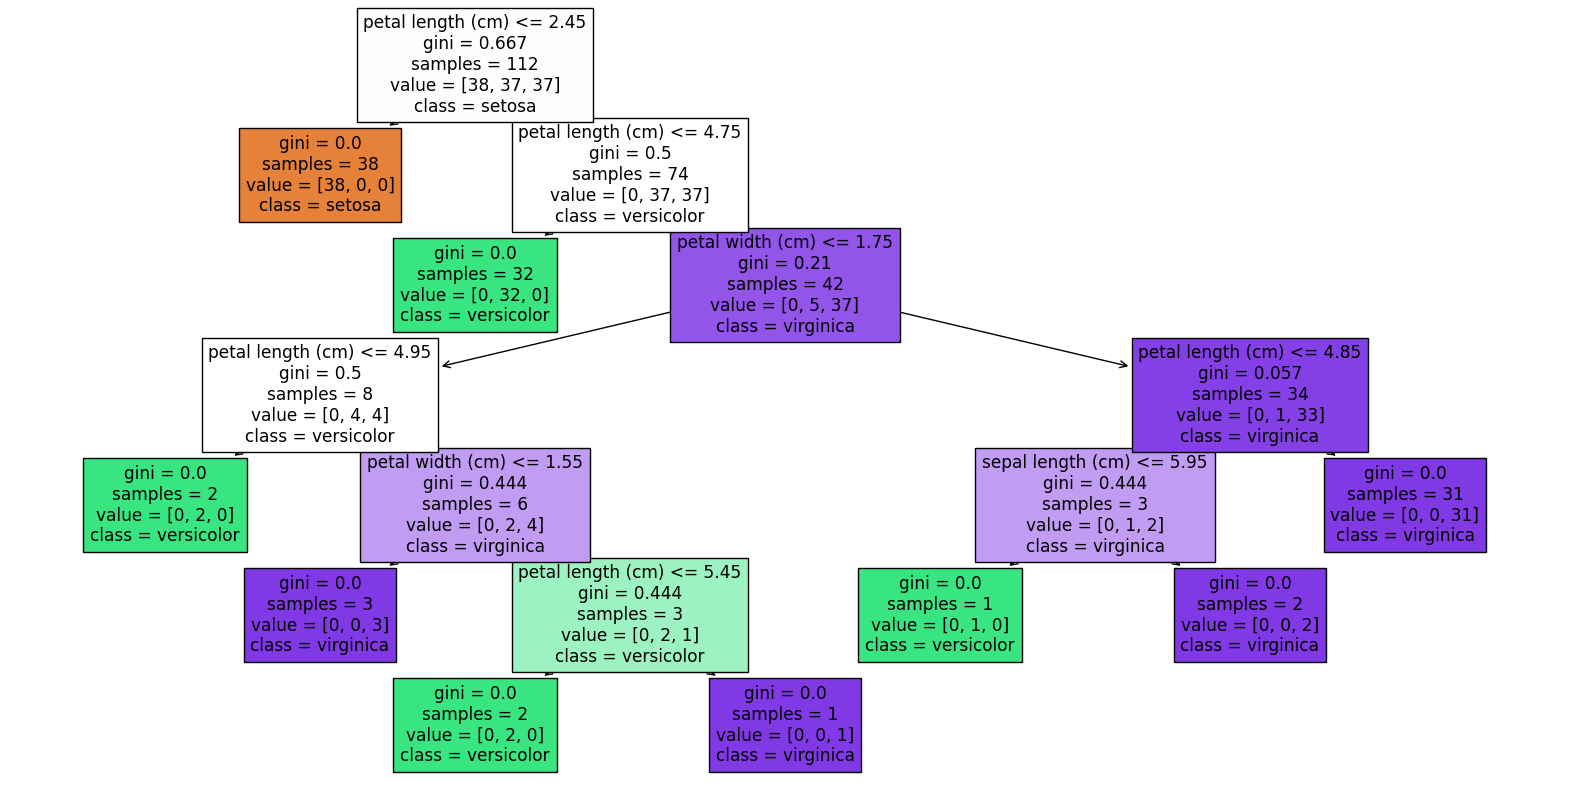

In [352]:
make_classification_report(DecisionTreeClassifier(random_state=42), make_plot=True)

In [353]:
kf = KFold(5)
halving_grid_search = HalvingGridSearchCV(estimator= DecisionTreeClassifier(), param_grid=params_grid, cv=kf, factor=2, random_state=42)
halving_grid_search.fit(iris_Xtr, iris_ytr)
simple_search = halving_grid_search.best_params_

In [354]:
simple_search, halving_grid_search.best_score_

({'ccp_alpha': 0.2,
  'criterion': 'log_loss',
  'max_depth': 3,
  'min_samples_leaf': 2},
 0.9303030303030303)

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        12
  versicolor       0.92      0.92      0.92        13
   virginica       0.92      0.92      0.92        13

    accuracy                           0.95        38
   macro avg       0.95      0.95      0.95        38
weighted avg       0.95      0.95      0.95        38



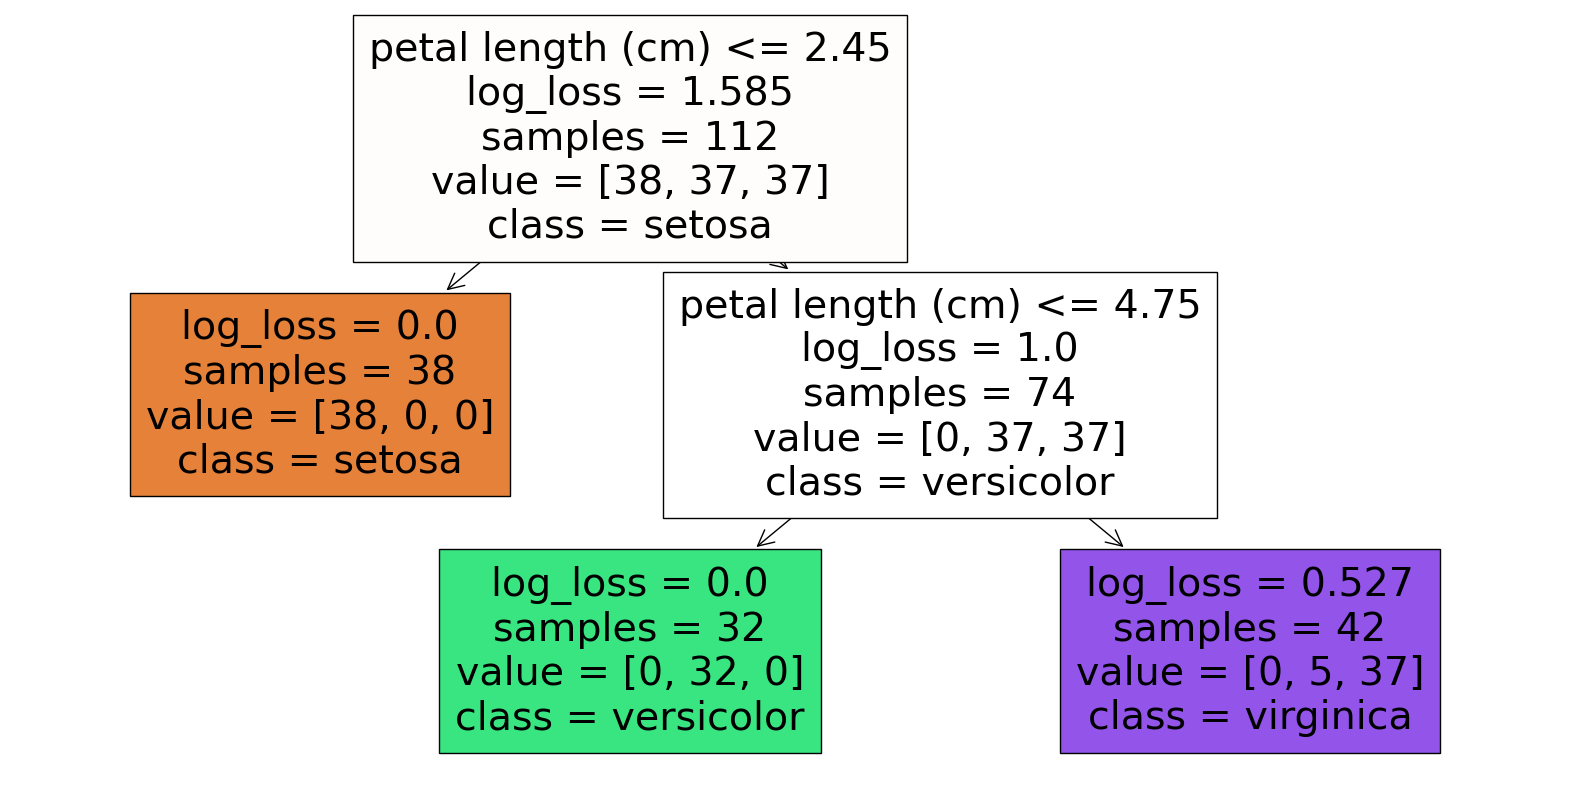

In [355]:
make_classification_report(DecisionTreeClassifier(**simple_search, random_state=42), make_plot= True)

In [356]:
simple_search['score'] = halving_grid_search.best_score_

In [357]:
kf = StratifiedKFold(5)
halving_grid_search_stratified = HalvingGridSearchCV(estimator= DecisionTreeClassifier(), param_grid=params_grid, cv=kf, factor=2, random_state=42)
halving_grid_search_stratified.fit(iris_Xtr, iris_ytr)
stratified_search = halving_grid_search_stratified.best_params_

In [358]:
stratified_search, halving_grid_search_stratified.best_score_

({'ccp_alpha': 0.2,
  'criterion': 'gini',
  'max_depth': 5,
  'min_samples_leaf': 4},
 0.9484848484848485)

# Class weight

In [359]:
make_classification_report(DecisionTreeClassifier(**stratified_search, random_state=42))

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        12
  versicolor       0.92      0.92      0.92        13
   virginica       0.92      0.92      0.92        13

    accuracy                           0.95        38
   macro avg       0.95      0.95      0.95        38
weighted avg       0.95      0.95      0.95        38



In [360]:
make_classification_report(DecisionTreeClassifier(**stratified_search, class_weight={0:1, 1:2, 2:3}, random_state=42))

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        12
  versicolor       0.92      0.92      0.92        13
   virginica       0.92      0.92      0.92        13

    accuracy                           0.95        38
   macro avg       0.95      0.95      0.95        38
weighted avg       0.95      0.95      0.95        38



In [361]:
stratified_search['score'] = halving_grid_search_stratified.best_score_

# Pcb

In [362]:
params_grid = {
    'Classifier__criterion': ['gini', 'entropy', 'log_loss'],
    'Classifier__max_depth': [None, 10, 20],
    'Classifier__min_samples_leaf': [1, 2, 4],
    'Classifier__ccp_alpha': [0.0, 0.1, 0.2]
}

In [363]:
pcb_pipe = Pipeline([('Outliers Remover', OutlierRemover()),('Simple Imputer', SimpleImputer(strategy='mean')), ('Standard Scaler', StandardScaler()),('Normalizer', MinMaxScaler())])

In [364]:
def classification_metrics_table(y_test, y_pred, target_names):
    classes = np.unique(y_test)
    metrics = ['accuracy', 'precision', 'recall', 'f1-score']
    
    # Obliczanie metryk dla każdej klasy
    data = {}
    for cls in classes:
        cls_data = {
            'accuracy': accuracy_score(y_test == cls, y_pred == cls),
            'precision': precision_score(y_test, y_pred, pos_label=cls, average='binary'),
            'recall': recall_score(y_test, y_pred, pos_label=cls, average = 'binary'),
            'f1-score': f1_score(y_test, y_pred, pos_label=cls, average = 'binary')
        }
        data[cls] = cls_data

    # Tworzenie DataFrame
    df = pd.DataFrame(data).T[metrics]
    return df



def make_classification_report_pcb(claf:DecisionTreeClassifier, make_plot = False):
    existing_steps = pcb_pipe.steps.copy()
    existing_steps.append(('Classifier',  claf))
    clf = Pipeline(existing_steps)
    clf.fit(pcb_Xtr, pcb_ytr)
    pcb_ypred = clf.predict(pcb_Xtst)
    print(classification_metrics_table(pcb_ytst, pcb_ypred, target_names=pcb['class'].unique().astype(str)))
    if make_plot:
        plt.figure(figsize=(20, 10))
        plot_tree(clf.named_steps['Classifier'], filled=True, feature_names=pcb.iloc[:, :-1].columns, class_names=pcb['class'].unique().astype(str))
        plt.show()

   accuracy  precision    recall  f1-score
0  0.961298   0.981009  0.978686  0.979846
1  0.961298   0.500000  0.529412  0.514286


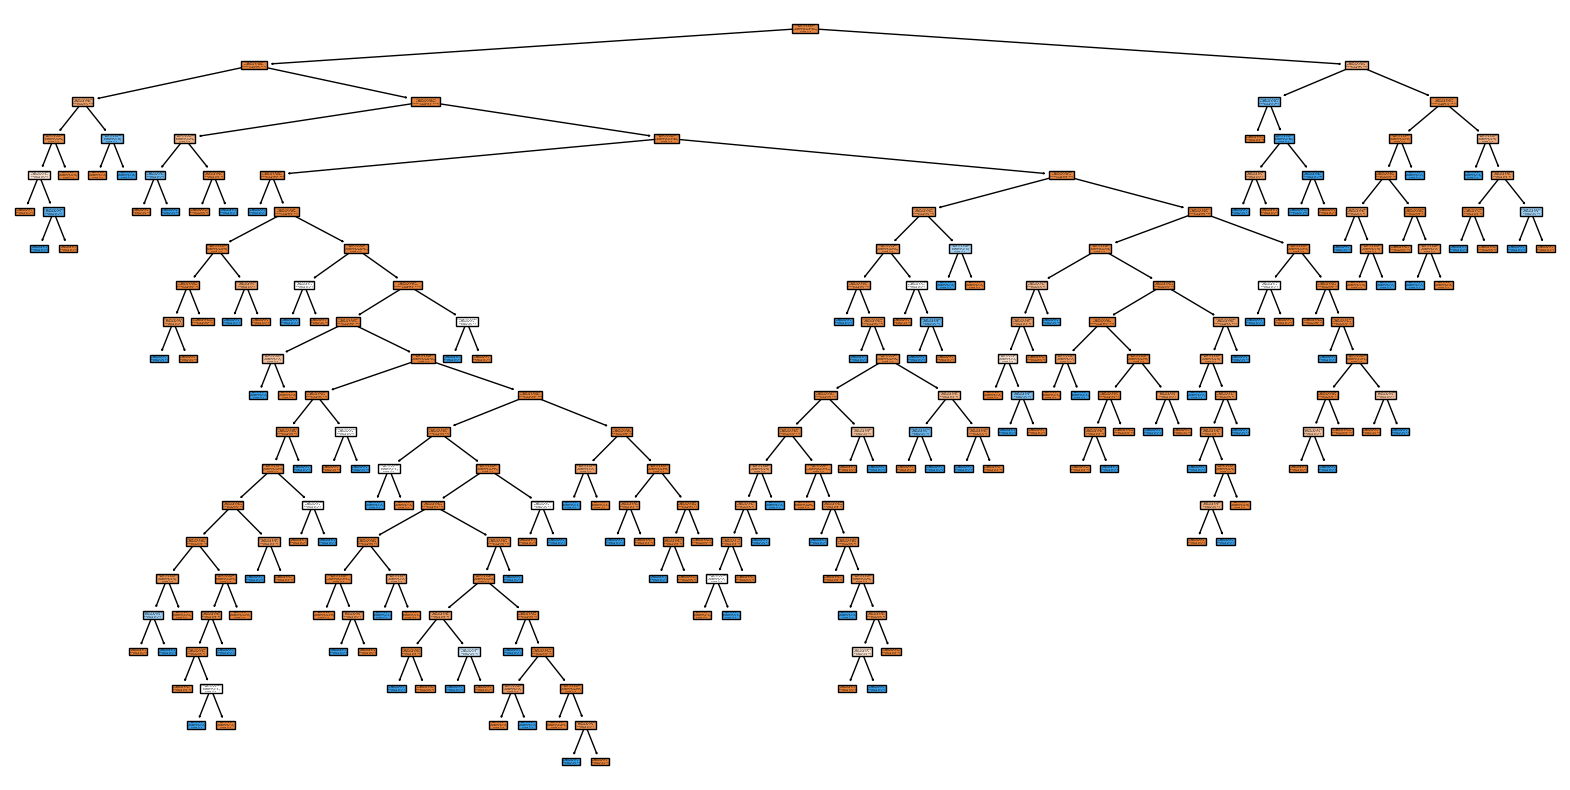

In [365]:
make_classification_report_pcb(DecisionTreeClassifier(random_state=42), make_plot=True)

In [366]:
existing_steps = pcb_pipe.steps.copy()
existing_steps.append(('Classifier',  DecisionTreeClassifier()))
pipeline = Pipeline(existing_steps)

In [367]:
kf = KFold(5)
halving_grid_search_pcb = HalvingGridSearchCV(estimator= pipeline, param_grid=params_grid, cv=kf, factor=2, random_state=42, scoring = make_scorer(recall_score, average = 'binary'))
halving_grid_search_pcb.fit(pcb_Xtr, pcb_ytr)
simple_search_pcb = halving_grid_search_pcb.best_params_

In [368]:
simple_search_pcb, halving_grid_search_pcb.best_score_

({'Classifier__ccp_alpha': 0.0,
  'Classifier__criterion': 'gini',
  'Classifier__max_depth': 20,
  'Classifier__min_samples_leaf': 1},
 0.5113771995284601)

In [369]:
simple_search_pcb = {key.split('__')[-1]:val for key, val in simple_search_pcb.items()}

In [370]:
make_classification_report_pcb(DecisionTreeClassifier(**simple_search_pcb, random_state=42))

   accuracy  precision    recall  f1-score
0  0.961298   0.981009  0.978686  0.979846
1  0.961298   0.500000  0.529412  0.514286


In [371]:
simple_search_pcb['score'] = halving_grid_search_pcb.best_score_

In [372]:
kf = StratifiedKFold(5)
halving_grid_search_stratified_pcb = HalvingGridSearchCV(estimator=pipeline, param_grid=params_grid, cv=kf, factor=2, random_state=42, scoring = make_scorer(recall_score, average = 'binary'))
halving_grid_search_stratified_pcb.fit(pcb_Xtr, pcb_ytr)
stratified_search_pcb = halving_grid_search_stratified_pcb.best_params_

In [373]:
stratified_search_pcb, halving_grid_search_stratified_pcb.best_score_

({'Classifier__ccp_alpha': 0.0,
  'Classifier__criterion': 'entropy',
  'Classifier__max_depth': None,
  'Classifier__min_samples_leaf': 1},
 0.500375234521576)

In [374]:
stratified_search_pcb = {key.split('__')[-1]:val for key, val in stratified_search_pcb.items()}

# Class weight

In [375]:
make_classification_report_pcb(DecisionTreeClassifier(**stratified_search_pcb, random_state=42))

   accuracy  precision    recall  f1-score
0  0.963005   0.981613  0.979870  0.980741
1  0.963005   0.521127  0.544118  0.532374


In [376]:
make_classification_report_pcb(DecisionTreeClassifier(**stratified_search_pcb, class_weight='balanced', random_state=42))

   accuracy  precision    recall  f1-score
0  0.956744   0.977501  0.977501  0.977501
1  0.956744   0.441176  0.441176  0.441176


In [377]:
make_classification_report_pcb(DecisionTreeClassifier(**stratified_search_pcb, class_weight={0:22,1:3}, random_state=42))

   accuracy  precision    recall  f1-score
0  0.969266   0.984014  0.984014  0.984014
1  0.969266   0.602941  0.602941  0.602941


In [378]:
stratified_search_pcb['score'] = halving_grid_search_stratified_pcb.best_score_

# Tabela z podsumowaniem

In [379]:
iris_scores = pd.DataFrame.from_dict(simple_search, orient='index', columns=['simple cv iris'])
iris_scores_str = pd.DataFrame.from_dict(stratified_search, orient='index', columns=['stratified cv iris'])
pcb_scores = pd.DataFrame.from_dict(simple_search_pcb, orient='index', columns=['simple cv pcb'])
pcb_scores_str = pd.DataFrame.from_dict(stratified_search_pcb, orient='index', columns=['stratified cv pcb'])

In [380]:
pd.concat([iris_scores, iris_scores_str, pcb_scores, pcb_scores_str], axis=1)

,simple cv iris,stratified cv iris,simple cv pcb,stratified cv pcb
ccp_alpha,0.2,0.2,0.0,0.0
criterion,log_loss,gini,gini,entropy
max_depth,3,5,20,None
min_samples_leaf,2,4,1,1
score,0.930303,0.948485,0.511377,0.500375
